In [21]:
# pip install git+https://github.com/IBM/terratorch.git ##used this code to get latest terratorch download

from Decoder_UNet2D import UNet2D
from Encoder_TerraMind import TerraMindEncoder
from DataLoader import BeforeData
# from Losses import DiceLoss
from monai.losses.dice import DiceLoss # replaced the above loss
from utils import RandomCrop, RandomFlipPair, RandomRotationPair, weights, calc_batch_metrics, calc_epoch_metrics



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np



In [22]:
# -----params----- #
learning_rate = 0.0005
num_classes = 3
num_augmentations = 6
batch_size = 3
num_epochs = 5
ignore_index = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
apply_weight = True

# ------Loading in models + data + helper functions --------- #
train_data = BeforeData(before_dir = os.getcwd()+ "/Images/Before",
                     after_dir = os.getcwd()+ "/Images/After",
                     label_dir = os.getcwd() + "/Images/Relabeled",
                     split = 'train', 
                     num_augmentations= num_augmentations)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = BeforeData(before_dir = os.getcwd()+ "/Images/Before",
                     after_dir = os.getcwd()+ "/Images/After",
                     label_dir = os.getcwd() + "/Images/Relabeled",
                     split = 'test')
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=2)


if apply_weight == True:
    weights_ = weights(train_dataloader, num_classes=num_classes, ignore_index=ignore_index, device = device)
    criterion = nn.CrossEntropyLoss(weight = weights_, ignore_index=ignore_index)
else:
    criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)


encoder = TerraMindEncoder()
decoder = UNet2D(num_classes=num_classes)
for param in encoder.parameters():
    param.requires_grad = False
encoder.to(device)
decoder.to(device)

optimizer = optim.Adam(#list(encoder.parameters()) + 
    list(decoder.parameters()),
     lr=learning_rate)

# ---- Training Loop ---- #
encoder.eval()
decoder.train()

train_losses = []
test_losses = []
metrics = []
for epoch in range(num_epochs):
    decoder.train() 
    running_train_loss = 0.0
    running_test_loss = 0.0
    TP = FP = FN = TN = 0.0
    
    for (x_before, x_after), y in train_dataloader:
        x_before, x_after, y = x_before.to(device), x_after.to(device), y.to(device)
        z_before = encoder(x_before)
        z_after = encoder(x_after)
        z_differenced = [after - before for before, after in zip(z_before, z_after)]
        logits = decoder(z_differenced)

        loss = criterion(logits, y)
        running_train_loss += loss.item() * x_before.size(0)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
              

    epoch_loss = running_train_loss / len(train_data)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

    decoder.eval()
    with torch.no_grad():
        iterations = 0
        val_loss = 0
        for (x_before, x_after), y in test_dataloader:
            x_before, x_after, y = x_before.to(device), x_after.to(device), y.to(device)
            z_before, z_after = encoder(x_before), encoder(x_after)
            z_differenced = [after - before for before, after in zip(z_before, z_after)]
            logits = decoder(z_differenced)
            
            test_loss = criterion(logits, y)
            running_test_loss += test_loss.item() * x_before.size(0)

            batch_metrics = calc_batch_metrics(logits, y, ignore_index=0, positive_class = 2, negative_class=1)
            TP, FP, FN, TN = [x + y for x, y in zip((TP, FP, FN, TN), batch_metrics)]

        
        final_test_loss = running_test_loss/len(test_data)
        test_losses.append(final_test_loss)
        print(f"--Test Loss: {test_loss.item()}")

        epoch_metrics = calc_epoch_metrics(TP, FP, FN, TN)
        metrics.append(epoch_metrics)
        print(f"-- Accuracy: {metrics[-1]["accuracy"]:.4f}\
        - Precision: {metrics[-1]["precision"]:.4f}\
        - Recall: {metrics[-1]["recall"]:.4f}\
        - F1: {metrics[-1]["F1"]:.4f}\
        - IoU: {metrics[-1]["IoU"]:.4f}\n")

Epoch 1/5 - Train Loss: 0.9786
--Test Loss: 0.8268435001373291
-- Accuracy: 0.0000        - Precision: 0.0000        - Recall: 0.0000        - F1: 0.0000        - IoU: 0.0000

Epoch 2/5 - Train Loss: 0.7933
--Test Loss: 0.30380433797836304
-- Accuracy: 0.0000        - Precision: 0.0000        - Recall: 0.0000        - F1: 0.0000        - IoU: 0.0000

Epoch 3/5 - Train Loss: 0.2268
--Test Loss: 0.27389079332351685
-- Accuracy: 0.0000        - Precision: 0.0000        - Recall: 0.0000        - F1: 0.0000        - IoU: 0.0000

Epoch 4/5 - Train Loss: 0.2022
--Test Loss: 0.0648593083024025
-- Accuracy: 0.0000        - Precision: 0.0000        - Recall: 0.0000        - F1: 0.0000        - IoU: 0.0000

Epoch 5/5 - Train Loss: 0.1540
--Test Loss: 0.15436232089996338
-- Accuracy: 0.0000        - Precision: 0.0000        - Recall: 0.0000        - F1: 0.0000        - IoU: 0.0000



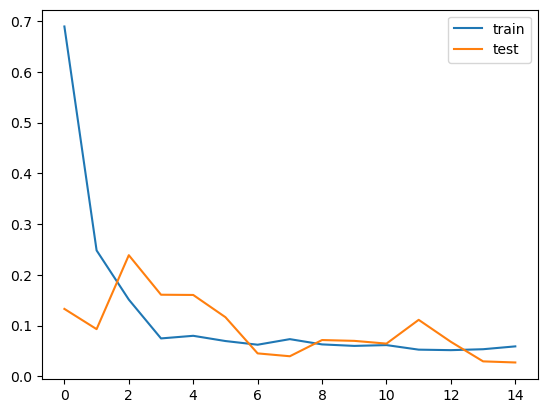

32


: 

In [20]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.legend()
plt.show()

print(len(train_data))

In [15]:

#plot Loss and Accuracy
# fig, ax1 = plt.subplots()

# # Plot losses on the left y-axis
# ax1.plot(losses, color="tab:red", label="Loss")
# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Loss", color="tab:red")
# ax1.tick_params(axis="y", labelcolor="tab:red")

# # Create a second y-axis that shares the same x-axis
# ax2 = ax1.twinx()
# ax2.plot(accuracies, color="tab:blue", label="Accuracy")
# ax2.set_ylabel("Accuracy", color="tab:blue")
# ax2.tick_params(axis="y", labelcolor="tab:blue")

# # Add legends
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# plt.title("Loss and Accuracy over Epochs")
# plt.show()

1

: 

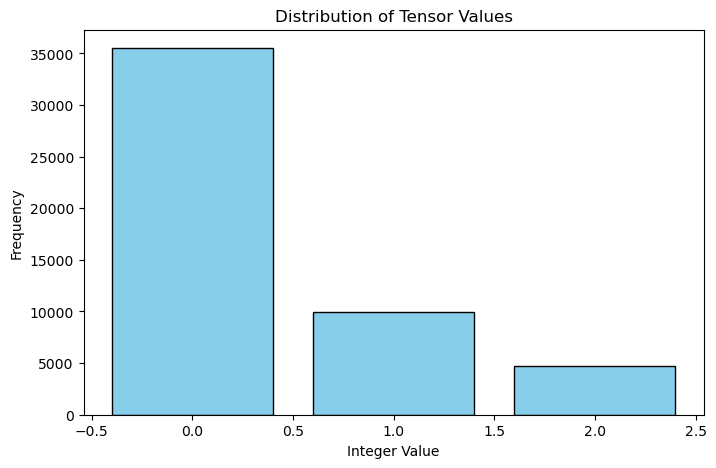

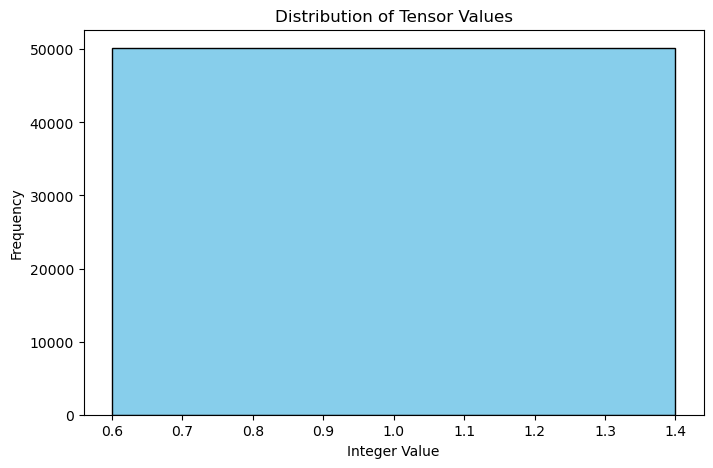

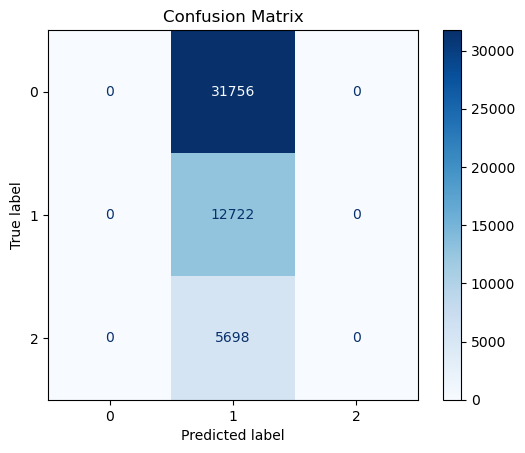

In [24]:
for i in test_dataloader:
    b, a, l = i[0][0], i [0][1], i[1]

l = l.flatten()
plt.figure(figsize=(8,5))
plt.hist(l, bins=range(l.min(),l.max()+2), align='left', rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Integer Value")
plt.ylabel("Frequency")
plt.title("Distribution of Tensor Values")
plt.show()


predictions = torch.argmax(logits, dim=1)
p = predictions.flatten()
plt.figure(figsize=(8,5))
plt.hist(p, bins=range(p.min(),p.max()+2), align='left', rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Integer Value")
plt.ylabel("Frequency")
plt.title("Distribution of Tensor Values")
plt.show()

cm = confusion_matrix(y.cpu().numpy().ravel(),predictions.cpu().numpy().ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
plt.title('Confusion Matrix')
plt.show()



Loss: tensor(0.1214)
Accuracy: 0.92635836802517


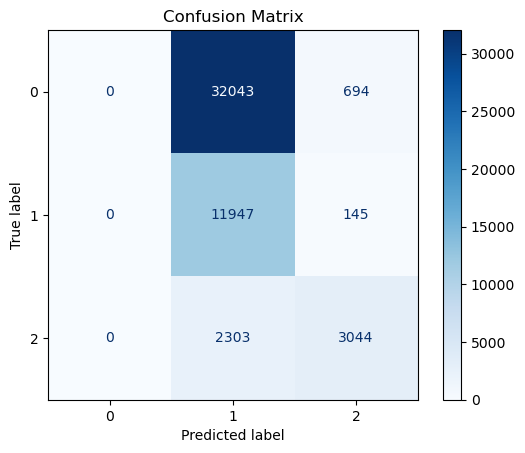

Accuracy: []


: 

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 3
ignore_index = 0
apply_weight = True

# encoder = TerraMindEncoder()
# decoder = UNet2D(num_classes = num_classes)
# encoder.to(device)
# decoder.to(device)

dataset = BeforeData(before_dir = os.getcwd()+ "/Images/Before",
                     after_dir = os.getcwd()+ "/Images/After",
                     label_dir = os.getcwd() + "/Images/Relabeled",
                     split = 'test')


dataloader = DataLoader(dataset)

if apply_weight == True:
    weights_ = weights(dataloader, num_classes=num_classes, ignore_index=ignore_index, device = device)
    criterion = nn.CrossEntropyLoss(weight = weights_, ignore_index=ignore_index)
else:
    criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

# ---- Test Loop ----
loss = []
accuracies = []
running_loss = 0.0

encoder.eval()
decoder.eval()
with torch.no_grad():  # no gradients for inference
    test_loss = 0
    for (x_before, x_after), y in dataloader:
        x_before, x_after, y = x_before.to(device), x_after.to(device), y.to(device)

        z_before = encoder(x_before)
        z_after = encoder(x_after)
        z_differenced = [after - before for before, after in zip(z_before, z_after)]

        logits = decoder(z_differenced)

        metrics = calculate_metrics(logits, y, mask)

        
        loss = criterion(logits, y)
        test_loss += loss


test_accuracy = total_correct/total_pixels
print("Loss:", test_loss)
print("Accuracy:", test_accuracy)    


# plt.plot(losses, label = "Loss")
# plt.plot(accuracies, label = "Accuracy")
# plt.legend()
# plt.show()

cm = confusion_matrix(y.cpu().numpy().ravel(), predictions.cpu().numpy().ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracies)

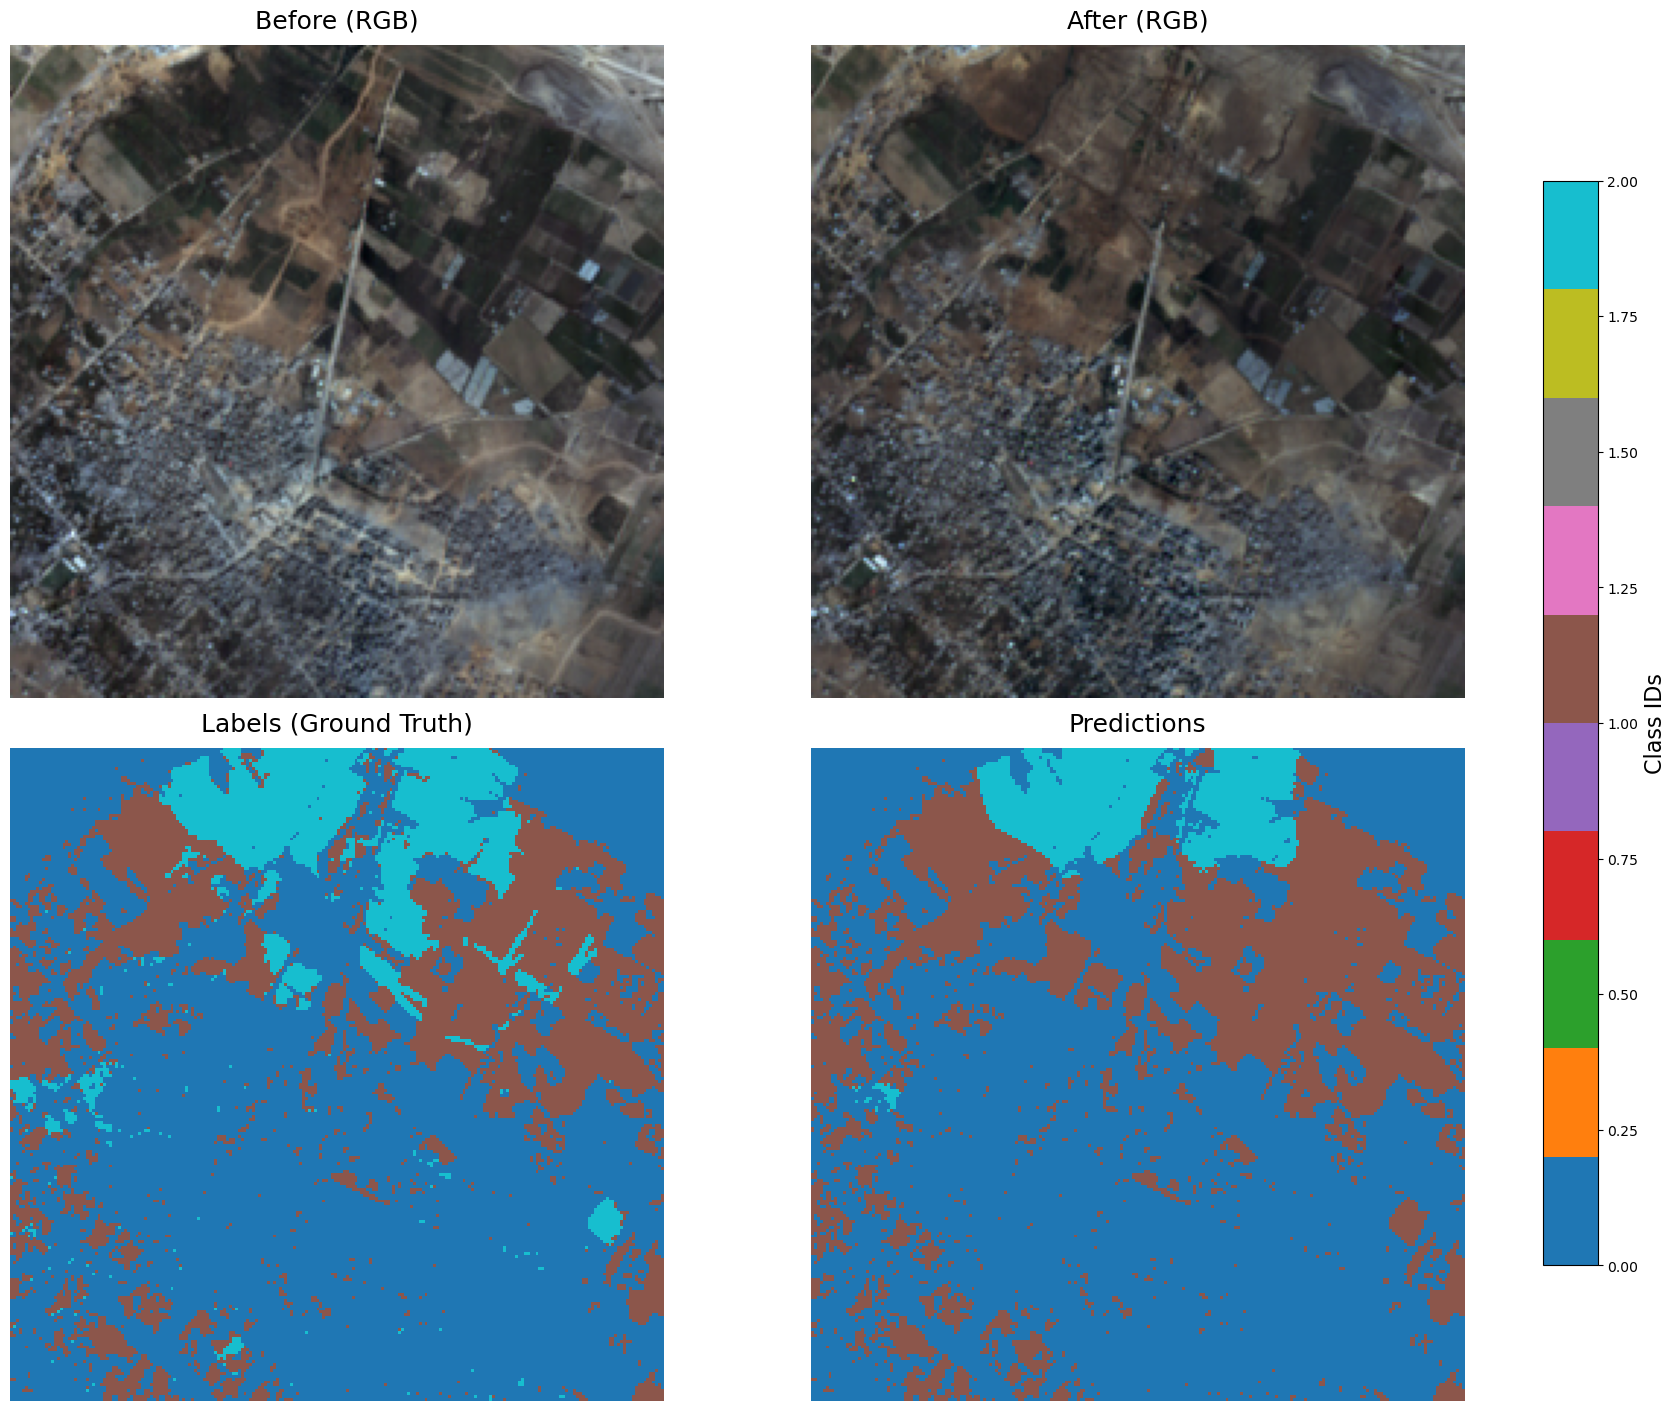

: 

In [ ]:
# predictions[y==0] = 0 


# x_before_img = x_before[0]
# x_after_img  = x_after[0] 
# y_img        = y[0]       
# pred_img     = predictions[0]

# # Setup 2x2 grid with constrained layout
# fig, axes = plt.subplots(2, 2, figsize=(18, 14), constrained_layout=True)

# # --- Before image (RGB: bands 4,3,2) ---
# rgb_before = x_before_img[[3, 2, 1], :, :].permute(1, 2, 0)
# rgb_before = (rgb_before - rgb_before.min()) / (rgb_before.max() - rgb_before.min())
# axes[0, 0].imshow(rgb_before.cpu())
# axes[0, 0].set_title("Before (RGB)", fontsize=18, pad=12)
# axes[0, 0].axis("off")

# # --- After image (RGB: bands 4,3,2) ---
# rgb_after = x_after_img[[3, 2, 1], :, :].permute(1, 2, 0)
# rgb_after = (rgb_after - rgb_after.min()) / (rgb_after.max() - rgb_after.min())
# axes[0, 1].imshow(rgb_after.cpu())
# axes[0, 1].set_title("After (RGB)", fontsize=18, pad=12)
# axes[0, 1].axis("off")

# # --- Ground truth labels ---
# im1 = axes[1, 0].imshow(y_img.cpu(), cmap="tab10", interpolation="nearest")
# axes[1, 0].set_title("Labels (Ground Truth)", fontsize=18, pad=12)
# axes[1, 0].axis("off")

# # --- Predictions ---
# im2 = axes[1, 1].imshow(pred_img.cpu(), cmap="tab10", interpolation="nearest")
# axes[1, 1].set_title("Predictions", fontsize=18, pad=12)
# axes[1, 1].axis("off")

# # Single shared colorbar (placed to the right of all plots)
# cbar = fig.colorbar(im2, ax=axes, shrink=0.8, location="right")
# cbar.set_label("Class IDs", fontsize=16)

# plt.show()